In [205]:
%matplotlib inline

import csv
import numpy as np 
import scipy as sp
import pandas as pd
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

In [206]:
PATH = "./movies_csv/"
NUM_OBS = 500

PLOT_DISABLE = 0
PLOT_ENABLE = 1

In [207]:
def getData(file):
    reader=csv.reader(open(file,"rb"),delimiter=',')
    x=list(reader)
    result=np.array(x).astype(np.float32)
    return result

In [208]:
def genC(n, w):
	w_cumul	= w.cumsum()
	c	= np.zeros((1,n))
	w_arr	= pd.Series(w_cumul)
	c 	= [w_arr[(w_arr > np.random.random())].index[0] for i in range(0,n)]		
	return c

In [209]:
def euclid(a,b):
    return np.linalg.norm(a-b)

In [210]:
def kmeans(x, k, iter_num, plot_req):
    ## Function takes inputs:
    ## x --> input data & k--> k value & iter_num --> number of iterations
    ## Returns:
    ## c --> cluster assignment, 
    ## mu--> mean of classes
    ## L --> Objective function value
    d = np.size(x,axis=1)
    n = np.size(x,axis=0)
    mu = np.random.rand(d,k) # 2xk in our case.
    c = np.zeros((n,1))
    L = np.zeros((1,iter_num))
    #print d,n
    
    #int_res = []  # Intermediate x-mu values for all mu.
    
    for i in range(0,iter_num):
            sum = 0
            temp_sum = np.zeros((d,k)) # holds summation xi (c=k)
            n_k = np.zeros(k) #holds nk
            for j in range(0,n):
                int_res = [euclid(x[j,:], mu[:,m])**2 for m in range(0,k)]
                c[j][0] = np.argmin(int_res)
                sum = sum + np.min(int_res)
                allo_k = int(c[j][0])
                n_k[allo_k] = n_k[allo_k]+1
                temp_sum[:,allo_k] = temp_sum[:,allo_k] + x[j,:]
            mu = temp_sum*1.0/n_k    
                
            L[0][i] = L[0][i-1] if np.isnan(sum) else sum 
    if (plot_req):        
        plt.clf()
        plt.scatter(x[:,0], x[:,1], c=c*500)
        plt.plot(mu[0,:],mu[1,:], 'rx')
        plt.title("Scatter plot for k=%d"%k)
        plt.savefig("./images/k_means_scatter_plot_k=%d.jpg"%k)
        plt.show()
    return c, mu , L

In [211]:
def part1():
    print "Running K-means."
    pi = np.array([0.2, 0.5, 0.3])
    c = genC(NUM_OBS,pi)
    mu = [[0,0],[3,0],[0,3]]
    sig = [[[1,0],[0,1]],
          [[1,0],[0,1]],
          [[1,0],[0,1]]]
    n = np.zeros(np.size(pi))
    samples = []
    for i in range(0,len(n)):
        n[i] = sum([elem==i for elem in c])
        samples=samples+list(np.random.multivariate_normal(mean =mu[i], cov=sig[i], size=int(n[i])))
    samples = np.array(samples)
    #print samples
    
    k_val = [2,3,4,5,6]
    L_list = []
    mu_list = []
    c_list = []
    for k in k_val:
        print "k=%d" %k
        c, mu , L = kmeans(samples, k, 20, PLOT_ENABLE)
        c_list.append(c)
        mu_list.append(mu)
        L_list.append(L)
        #print L
    #print L_list
    
    plt.clf()
    for idx,L in enumerate(L_list):
    #    print str(idx+2) +":"
    #    print (L[0])
        
        plt.plot(L[0], label="L=%d"%(idx+2))
    
    plt.xlabel("Iteration Number")
    plt.ylabel("L values")
    plt.title("Plot of Objective Functions")
    plt.legend(loc='upper right', shadow=True)
    plt.savefig("./images/k_means_L_plot.jpg")
    plt.show()
    
    

In [215]:
def rmse(array):
    return np.sqrt(np.mean(np.array(array)**2))

In [217]:
def checkM(M):
    for i,row in enumerate(M):
        for j,col in enumerate(row):
            if M[i,j]<1:
                M[i,j]=1
            elif M[i,j]>5:
                M[i,j]=5
    return M

In [218]:
def findIdx(matrix):
    idx_arr=[]
    for idx,row in enumerate(matrix):
        tem_list=[]
        for i,col in enumerate(row):
            if col != 0:
                tem_list.append(i)
        idx_arr.append(tem_list)
    return idx_arr

In [278]:
def calcLL(u, v, y_calc, y_train, lam, var):
    N1 = np.size(u, axis=0) #N1-->number of users 
    N2 = np.size(v, axis=0) #N2-->number of movies
    d  = np.size(u, axis=1) #d --> rank of matrix
    
    lnpUi = -(lam / 2.0) * (u ** 2).sum(axis=1).sum()
    lnpVj = -(lam / 2.0) * (v ** 2).sum(axis=1).sum()
    
    lnMij = 0.5/var * ((y_calc-y_train)**2).sum()

    
    L= -(lnMij + lnpUi + lnpVj)
    return L

In [350]:
def main():
    #part1()
    part2()

In [353]:
def part2():
    X_train = np.genfromtxt("./movies_csv/ratings.txt", delimiter=',', dtype='int32')
    X_test = np.genfromtxt("./movies_csv/ratings_test.txt", delimiter=',', dtype='int32')
    label = np.genfromtxt("./movies_csv/movies.txt", dtype='string', delimiter='\n')
    
    NUM_ITER = 100
    
    # creating an (i,j)
    
    X_train[:,0:2]= X_train[:,0:2]-1
    X_test[:,0:2]= X_test[:,0:2]-1
    y_train = X_train[:,2]
    y_test = X_test[:,2]
    
    N1 = np.max(X_train[:,0]) + 1 # max user id
    N2 = np.max(X_train[:,1]) + 1# max movie id
    
    d   = 10
    lam = 10
    var = 0.25
    
    iden = lam * var * np.eye(d)
    
    ## Generate the j_train: User ID's for each user who rated the film j
    ## & film_rating by that user
    j_train = []
    film_rating = []
    for j in range(0,N2):   # iterate through each movie
            idx = np.argwhere(X_train[:,1]== j)
            j_train.append(X_train[idx,0])
            film_rating.append(X_train[idx,2])            
                
    ## Generate the i_train: Film ID's for each film rated by user i
    ## & user_rating for all films
    i_train = []
    user_rating = []
    for i in range(0,N1):   # iterate through each user
            idx = np.argwhere(X_train[:,0]== i)
            i_train.append(X_train[idx,1])
            user_rating.append(X_train[idx,2])            
    
    
    v = np.random.multivariate_normal(mean =np.zeros(d), cov=(1.0/lam)*np.eye(d), size=N2)
    u = np.random.multivariate_normal(mean =np.zeros(d), cov=(1.0/lam)*np.eye(d), size=N1)
    
    err_list = []
    L_list = []
    for iteration in range(0,NUM_ITER):
        print "%d th iteration"%iteration
        
        for i in range(0,N1):
            #print i
            term1 = iden
            term2 = np.zeros((d,d))
            for ind in i_train[i]:
                term2 = term2 + np.dot(v[ind,:].T,v[ind,:])
            term3 = np.zeros(d)
            for idx,ind in enumerate(i_train[i]):
                #print ind
                term3 = term3 + np.dot(user_rating[i][idx],v[ind,:])
            u[i,:] = np.dot(np.linalg.inv(term1+term2),term3)
            
            
        for j in range(0,N2):
            term1 = iden
            term2 = np.zeros((d,d))
            term3 = np.zeros(d)
            
            for ind in j_train[j]:
                term2 = term2 + np.dot(u[ind,:].T,u[ind,:])
            for idx,ind in enumerate(j_train[j]):
                term3 = term3 + np.dot(film_rating[j][idx],u[ind,:])
            v[j,:] = np.dot(np.linalg.inv(term1+term2),term3)
                
        u_v = np.dot(u,v.T)
        y_pred = np.round(u_v[X_test[:,0],X_test[:,1]])
        
        err_list.append(rmse(y_pred - y_test))
       
        L_list.append(calcLL(u, v, np.round(u_v[X_train[:,0],X_train[:,1]]), y_train,lam,var))

    #part 2.1    
    plt.clf()
    plt.plot(err_list)
    plt.savefig("./images/rmse_plot.jpg")
    plt.title("RMSE plot vs iterations")
    plt.xlabel("Iteration Number")
    plt.ylabel("RMSE Value")
    plt.show()

    plt.clf()
    plt.plot(err_list[2:])
    plt.savefig("./images/rmse_plot_2on.jpg")
    plt.title("RMSE plot vs iterations")
    plt.xlabel("Iteration Number (2 to 100)")
    plt.ylabel("RMSE Value")
    plt.show()

    #part 2.2
    plt.clf()
    plt.plot(L_list)
    plt.savefig("./images/LL_plot.jpg")
    plt.xlabel("Iteration Number")
    plt.ylabel("Log Likelihood Value")
    plt.title("Log Likelihood vs Iterations")
    plt.show()

    plt.clf()
    plt.plot(L_list)
    plt.savefig("./images/LL_plot_2on.jpg")
    plt.xlabel("Iteration Number (2 to 100)")
    plt.ylabel("Log Likelihood Value")
    plt.title("Log Likelihood vs Iterations")
    plt.show()

    #part 2.3
    NUM_MOV = 5
    mov_idx = [184,95,98]
    for idx in mov_idx:
        mov = v[idx,:]
        print "For the movie '%s',"%label[idx]
        dist = []
        for movie in v:
            dist.append(euclid(movie,mov))
        idx = np.argsort(np.array(dist))[:NUM_MOV+1]
        print "Recommended Movies:\n\tScore\tMovie Name"
        for i in idx[1:]:
            print "\t",str(dist[i]),"\t",label[i]
            
    print "\n\nPart 2.4:"
    # part 2.4
    MOV_PER_CLUSTER = 10
    NUM_CLUS = 5
    c,mu,L = kmeans(u, 20, 1, PLOT_DISABLE)
    indices = np.argsort(Counter(c.T[0]).values())[::-1][:NUM_CLUS]
    
    for index in indices:
        centroid = mu[:,index].T
        
        centroid = [np.random.rand() if np.isnan(elem) else elem for elem in centroid]
        num_users = Counter(c.T[0]).values()[index]
        print "\tFor user cluster %d, we have %d users."%(index,num_users)
        dt_prod = []
        for movie in v:
            dt_prod.append(np.dot(centroid,movie.T))
        idx = np.argsort(dt_prod)[::-1][:MOV_PER_CLUSTER]    
        print "\t\tDot Prod\tMovie"
        for i in idx:
            print "\t\t%s\t%s"%(str(dt_prod[i]),label[i])
    
    print "\n\nPart 2.5:"
    # part 2.5
    c,mu,L = kmeans(v, 20, 1, PLOT_DISABLE)
    indices = np.argsort(Counter(c.T[0]).values())[::-1][:NUM_CLUS]
    for index in indices:
        centroid = mu[:,index].T
        centroid = [np.random.rand() if np.isnan(elem) else elem for elem in centroid]
        num_users = Counter(c.T[0]).values()[index]
        print "\tFor the movie cluster %d, we have %d movies."%(index,num_users)
        dist = []
        for movie in v:
            dist.append(euclid(centroid,movie))
        idx = np.argsort(dist)[:MOV_PER_CLUSTER]    
        print "\t\tEuclid Dist\tMovie"
        for i in idx:
            print "\t\t%s\t%s"%(str(dt_prod[i]),label[i])
    

0 th iteration
1 th iteration
2 th iteration
3 th iteration
4 th iteration
5 th iteration
6 th iteration
7 th iteration
8 th iteration
9 th iteration
10 th iteration
11 th iteration
12 th iteration
13 th iteration
14 th iteration
15 th iteration
16 th iteration
17 th iteration
18 th iteration
19 th iteration
20 th iteration
21 th iteration
22 th iteration
23 th iteration
24 th iteration
25 th iteration
26 th iteration
27 th iteration
28 th iteration
29 th iteration
30 th iteration
31 th iteration
32 th iteration
33 th iteration
34 th iteration
35 th iteration
36 th iteration
37 th iteration
38 th iteration
39 th iteration
40 th iteration
41 th iteration
42 th iteration
43 th iteration
44 th iteration
45 th iteration
46 th iteration
47 th iteration
48 th iteration
49 th iteration
50 th iteration
51 th iteration
52 th iteration
53 th iteration
54 th iteration
55 th iteration
56 th iteration
57 th iteration
58 th iteration
59 th iteration
60 th iteration
61 th iteration
62 th iteration
63

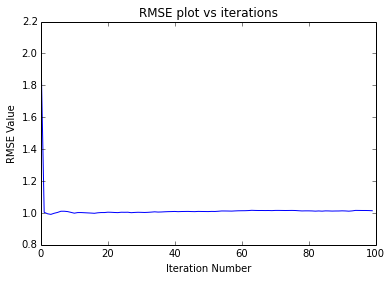

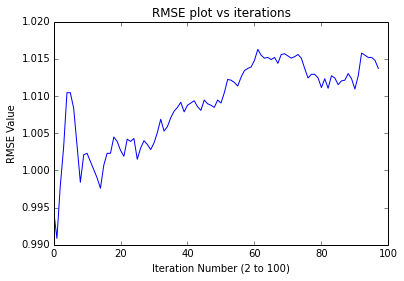

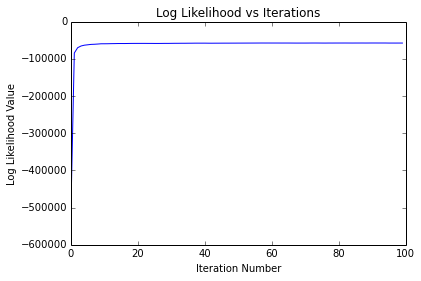

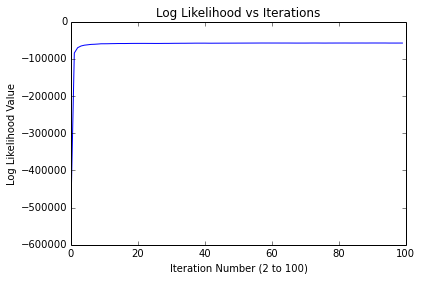

For the movie 'Psycho (1960)',
Recommended Movies:
	Score	Movie Name
	0.637828924587 	Some Like It Hot (1959)
	0.641833596528 	High Noon (1952)
	0.661494252524 	North by Northwest (1959)
	0.699209860021 	Birds, The (1963)
	0.788328203902 	Microcosmos: Le peuple de l'herbe (1996)
For the movie 'Terminator 2: Judgment Day (1991)',
Recommended Movies:
	Score	Movie Name
	0.490976969959 	Terminator, The (1984)
	0.698379856886 	Aliens (1986)
	0.715552812183 	Indiana Jones and the Last Crusade (1989)
	0.747514160432 	Jurassic Park (1993)
	0.751571319589 	Men in Black (1997)
For the movie 'Snow White and the Seven Dwarfs (1937)',
Recommended Movies:
	Score	Movie Name
	0.473230581269 	Pinocchio (1940)
	0.556063575415 	Roman Holiday (1953)
	0.607035490675 	Wizard of Oz, The (1939)
	0.630547628577 	Dumbo (1941)
	0.636823645917 	Cinderella (1950)


Part 2.4:
	For user cluster 1, we have 421 users.
		Dot Prod	Movie
		2.40956145983	Fire Down Below (1997)
		2.39524867686	Night of the Living Dead (196

In [354]:
main()